In [20]:
using DataFrames, CSV, Tables, Dates, Missings, Impute, Plots, Interpolations, Statistics, LinearAlgebra

## Load the data
This was generated with the NOAA web-tool through:

https://www.ncdc.noaa.gov/cdo-web/datatools/lcd

Search for Boston and then download. The current dataset was made small "on-purpose" and only has historical data from 2018-1-1 to sometime in November this year.

Review old orders:

https://www.ncdc.noaa.gov/cdo-web/orders?email=norheim@mit.edu


### file select

In [21]:
#df = CSV.File("hanscom.csv", index=) |> DataFrame;

In [22]:
df = CSV.File("boston.csv") |> DataFrame;

## Extract daily and hourly time series of data

In [23]:
dfdaily = filter(row -> strip(row[:REPORT_TYPE]) == "SOD", df);

In [24]:
dfh = filter(row -> !(strip(row[:REPORT_TYPE]) in ["SOD", "SOM"]), df) # these are the entries that correspond to daily and monthly data which we exclude;

In [25]:
sum(ismissing.(dfh[:, :HourlyDryBulbTemperature]))

0

## Imput missing and resample

In [26]:
match(r"[+-]?([0-9]*[.])?[0-9]+","asd")==nothing

true

In [27]:
function clean(x)
    if ismissing(x) || x isa Float64
        return x
    end
    m = match(r"[+-]?([0-9]*[.])?[0-9]+",x)
    return m ==nothing ? missing : parse(Float64, m.match)
    end;

https://www.reddit.com/r/Julia/comments/evpofl/resampling_a_dataframe_to_hourly_15min_and_5min/

In [28]:
function resample(dfh, factor)
    dfh[!,factor] = clean.(dfh[:,factor])
    timeseries = Impute.interp(dfh[!, [:DATE, factor]]) |> Impute.locf() |> Impute.nocb() 
    timeseries[!, factor] = convert.(Float64, timeseries[!, factor]) # remove the missing type
    # even sampling
    timeseries[!, :rounded] = map((d) -> round(d, Dates.Hour), timeseries[!, :DATE])
    even_sampling = by(timeseries, :rounded, factor => mean)
    rename!(even_sampling, Symbol(factor, "_mean") => :data)
    return even_sampling
    end;

## Recover data we care about

In [29]:
factors = [:HourlyDryBulbTemperature, :HourlyPrecipitation, :HourlySeaLevelPressure];

In [30]:
temp = resample(dfh, :HourlyDryBulbTemperature)
prec = resample(dfh, :HourlyPrecipitation)
pres = resample(dfh, :HourlySeaLevelPressure);

## Lets just look at 72hr of data sometime in summer

In [49]:
d1 = filter(row -> DateTime(2018, 7, 7, 0 ,0)<=row[:rounded]<=DateTime(2018, 7, 10, 0, 0), temp); # 7/7 - 7/10 for temp
d2 = filter(row -> DateTime(2018, 4, 1, 0 ,0)<=row[:rounded]<=DateTime(2018, 5, 1, 0, 0), prec); # 7/7 - 7/10 for temp

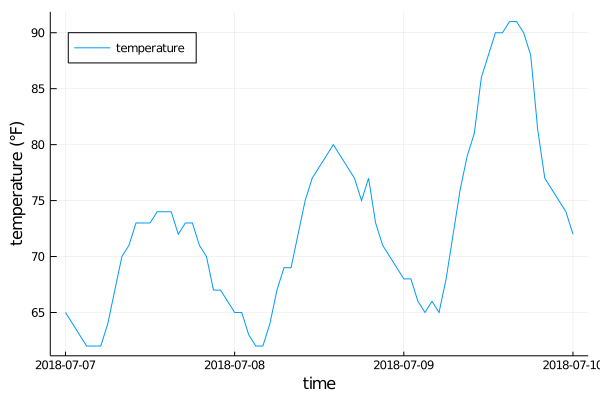

In [43]:
p1=plot(d1[!, :rounded], d1[!, :data], label="temperature", legend=:topleft, xlabel="time", ylabel="temperature (°F)")

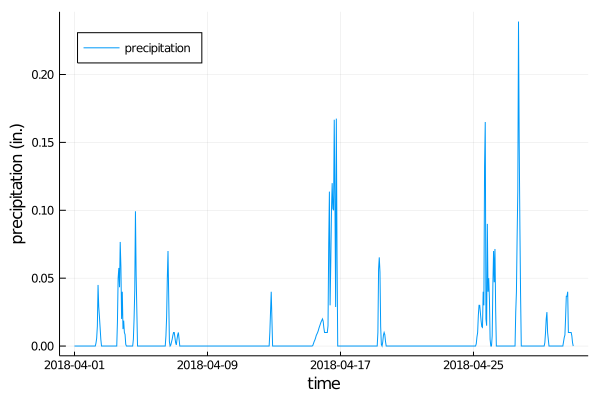

In [53]:
p2=plot(d2[!, :rounded], d2[!, :data], label="precipitation", legend=:topleft, xlabel="time", ylabel="precipitation (in.)")

In [52]:
savefig("precipitation.png")

In [42]:
DateTime(2019,1,1)+Dates.Hour.(1:24)

24-element Array{DateTime,1}:
 2019-01-01T01:00:00
 2019-01-01T02:00:00
 2019-01-01T03:00:00
 2019-01-01T04:00:00
 2019-01-01T05:00:00
 2019-01-01T06:00:00
 2019-01-01T07:00:00
 2019-01-01T08:00:00
 2019-01-01T09:00:00
 2019-01-01T10:00:00
 2019-01-01T11:00:00
 2019-01-01T12:00:00
 2019-01-01T13:00:00
 2019-01-01T14:00:00
 2019-01-01T15:00:00
 2019-01-01T16:00:00
 2019-01-01T17:00:00
 2019-01-01T18:00:00
 2019-01-01T19:00:00
 2019-01-01T20:00:00
 2019-01-01T21:00:00
 2019-01-01T22:00:00
 2019-01-01T23:00:00
 2019-01-02T00:00:00

We can see temperatures mostly go up during the day and come back at night as expected

## Creating the data for training

Running the following code generates quite a big matrix (and actually takes a second or two to run on my computer)

In [13]:
historical_data = 5 # number of days for which we have historical data(at hourly intervals)
t0 = DateTime(2018, 1, 1+historical_data, 0, 0)
training_days = 100
X = zeros(training_days, 24*historical_data)
y = zeros(training_days)
for day=1:training_days
    date = t0 + Day(day)
    X[day, :] = filter(row -> date - Day(historical_data)<= row[:rounded] <= date - Hour(1), temp_even_sampling)[!,:HourlyDryBulbTemperature_mean]
    y[day] = first(filter(row -> floor(row[:DATE], Day)==date, dfdaily))[:DailyAverageDryBulbTemperature]
end

In [14]:
(train_X, train_y), (test_X, test_y) = IAI.split_data(:regression, X, y);

In [17]:
grid = IAI.GridSearch(
    IAI.OptimalTreeRegressor(
        random_seed=123,
        show_progress=false,
    ),
    max_depth=1:5,
    show_progress=false
)
IAI.fit!(grid, train_X, train_y);

In [18]:
IAI.get_learner(grid)

Fitted OptimalTreeRegressor:
  1) Split: x120 < 40.75
    2) Split: x119 < 27.5
      3) Predict: 26.17, 12 points, error 247.7
      4) Predict: 36.93, 42 points, error 916.8
    5) Predict: 47.56, 16 points, error 553.9

# Testing

In [19]:
predicted_y = IAI.predict(grid, test_X);
norm(predicted_y - test_y, 2)

40.834613921159296

In [20]:
size(test_y)

(30,)

So each is off by about 6.741 (like on average). I'd say that's not bad, but maybe it could be improved

# Trying to make it hour by hour

In [21]:
historical_data = 5 # number of days for which we have historical data(at hourly intervals)
t0 = DateTime(2018, 1, 1+historical_data, 0, 0)
training_days = 100
X = zeros(24*training_days, 24*historical_data)
y = zeros(24*training_days)
for day=1:training_days
    for hour=0:23
        date = t0 + Day(day) + Hour(hour)
        X[24*(day-1)+hour+1, :] = filter(row -> date - Day(historical_data)<= row[:rounded] <= date - Hour(1), temp_even_sampling)[!,:HourlyDryBulbTemperature_mean]
        y[24*(day-1)+hour+1] = first(filter(row -> row[:rounded]==date, temp_even_sampling))[:HourlyDryBulbTemperature_mean]
    end
end

In [22]:
(train_X, train_y), (test_X, test_y) = IAI.split_data(:regression, X, y);

In [23]:
grid = IAI.GridSearch(
    IAI.OptimalTreeRegressor(
        random_seed=123,
        show_progress=false
    ),
    max_depth=1:5,
    show_progress=false 
)
IAI.fit!(grid, train_X, train_y);

In [24]:
IAI.get_learner(grid)

Fitted OptimalTreeRegressor:
  1) Split: x120 < 34.13
    2) Split: x120 < 23.5
      3) Split: x3 < 13.5
        4) Predict: -0.8571, 7 points, error 20.86
        5) Split: x120 < 17.5
          6) Predict: 14.72, 41 points, error 198.6
          7) Predict: 21.09, 76 points, error 272.9
      8) Split: x120 < 29.8
        9) Split: x120 < 26.25
          10) Predict: 25.37, 65 points, error 141.1
          11) Predict: 28.02, 111 points, error 260.6
        12) Split: x120 < 32.13
          13) Predict: 31.4, 201 points, error 464.8
          14) Predict: 33.44, 171 points, error 261.8
    15) Split: x120 < 44.8
      16) Split: x120 < 39.25
        17) Split: x120 < 36.75
          18) Predict: 35.66, 158 points, error 361.6
          19) Predict: 38.04, 283 points, error 592.5
        20) Split: x120 < 41.13
          21) Predict: 40.43, 134 points, error 245.5
          22) Predict: 42.86, 131 points, error 555.9
      23) Split: x120 < 56.25
        24) Split: x120 < 49.13
          25) Predict: 46.97, 162 points, error 798.6
          26) Predict: 51.52, 87 points, error 743.3
        27) Split: x120 < 62.5
          28) Predict: 58.23, 37 points, error 240.3
          29) Predict: 66.88, 16 points, error 87.75

In [26]:
predicted_y = IAI.predict(grid, test_X);
norm(predicted_y - test_y, 2)

56.88758540804785

In [31]:
size(test_y)

(720,)

So they're off by about 2.010

# What if we have to predict a day before

In [27]:
historical_data = 8 # number of days for which we have historical data(at hourly intervals)
t0 = DateTime(2018, 1, 1+historical_data, 0, 0)
training_days = 100
X = zeros(24*training_days, 24*(historical_data-1));
y = zeros(24*training_days)
for day=1:training_days
    for hour=0:23
        date = t0 + Day(day) + Hour(hour)
        X[24*(day-1)+hour+1, :] = filter(row -> date - Day(historical_data)<= row[:rounded] <= date - Hour(25), temp_even_sampling)[!,:HourlyDryBulbTemperature_mean]
        y[24*(day-1)+hour+1] = first(filter(row -> row[:rounded]==date, temp_even_sampling))[:HourlyDryBulbTemperature_mean]
    end
end

In [28]:
(train_X, train_y), (test_X, test_y) = IAI.split_data(:regression, X, y);

Training time ~ 10min :

In [36]:
grid = IAI.GridSearch(
    IAI.OptimalTreeRegressor(
        random_seed=123,
        show_progress=false
    ),
    max_depth=1:5,
    show_progress=false # <-- uncomment to avoid having all the progress bars show up
)
IAI.fit!(grid, train_X, train_y);

In [19]:
IAI.get_best_params(grid)

Dict{Symbol,Any} with 3 entries:
  :max_depth     => 6
  :cp            => 2.97384e-5
  :show_progress => false

In [35]:
IAI.get_learner(grid)

Fitted OptimalTreeRegressor:
  1) Split: x167 < 35.13
    2) Split: x117 < 20.75
      3) Split: x154 < 33.5
        4) Split: x21 < 33.5
          5) Split: x127 < 14.5
            6) Predict: 30.24, 7 points, error 11.05
            7) Predict: 32.83, 16 points, error 6.667
          8) Split: x87 < 17
            9) Predict: 29.5, 6 points, error 3.5
            10) Predict: 24.23, 13 points, error 30.31
        11) Split: x31 < 42
          12) Split: x1 < 8
            13) Predict: 27.4, 5 points, error 1.2
            14) Predict: 34.27, 11 points, error 4.182
          15) Split: x1 < 23
            16) Predict: 12.67, 3 points, error 18.67
            17) Predict: 21, 3 points, error 8
      18) Split: x168 < 25.5
        19) Split: x2 < 27.5
          20) Split: x129 < 42.1
            21) Predict: 25.23, 31 points, error 291.4
            22) Predict: 17.34, 28 points, error 179
          23) Split: x156 < 30.25
            24) Predict: 33.91, 61 points, error 1373.9
            25) Predict: 23.97, 29 points, error 387
        26) Split: x150 < 31.67
          27) Split: x139 < 29.5
            28) Predict: 42.02, 74 points, error 2845.7
            29) Predict: 35.59, 100 points, error 2616.9
          30) Split: x98 < 44.5
            31) Predict: 33.82, 263 points, error 8439.1
            32) Predict: 44.93, 59 points, error 1487.2
    33) Split: x23 < 24.33
      34) Split: x26 < 19.25
        35) Split: x135 < 41
          36) Split: x51 < 13
            37) Predict: 56.2, 19 points, error 203.8
            38) Predict: 35.44, 27 points, error 76.7
          39) Split: x23 < 5
            40) Predict: 16.39, 9 points, error 34.89
            41) Predict: 23.17, 6 points, error 28.83
        42) Split: x12 < 27.5
          43) Split: x33 < 20.5
            44) Predict: 46.8, 5 points, error 6.8
            45) Predict: 35.26, 14 points, error 187
          46) Split: x1 < 32
            47) Predict: 47.43, 7 points, error 17.71
            48) Predict: 25.18, 17 points, error 76.97
      49) Split: x97 < 32.7
        50) Split: x45 < 47.58
          51) Split: x76 < 47
            52) Predict: 35.89, 132 points, error 6388
            53) Predict: 61.3, 10 points, error 700.1
          54) Split: x19 < 36.63
            55) Predict: 16.33, 12 points, error 514.7
            56) Predict: 49.33, 6 points, error 271.3
        57) Split: x51 < 27.5
          58) Split: x89 < 37.5
            59) Predict: 37.44, 9 points, error 36.22
            60) Predict: 24.12, 17 points, error 119.8
          61) Split: x168 < 42.75
            62) Predict: 39.14, 416 points, error 13105.7
            63) Predict: 44.58, 265 points, error 15770.6

In [31]:
predicted_y = IAI.predict(grid, test_X);
norm(predicted_y - test_y, 2)

177.1497494705143

In [32]:
size(test_y)

(720,)

# Adding in MM/DD/HOUR and minbucket

In [122]:
@time begin
historical_data = 5 # number of days for which we have historical data(at hourly intervals)
t0 = DateTime(2018, 1, 1+historical_data, 0, 0)
training_days = 360
X = zeros(24*training_days, 24*historical_data + 3)
y = zeros(24*training_days)
for day=1:training_days
    for hour=0:23
        date = t0 + Day(day) + Hour(hour)
        X[24*(day-1)+hour+1, 1:(24*historical_data)] = filter(row -> date - Day(historical_data)<= row[:rounded] <= date - Hour(1), temp)[!,:data]
        X[24*(day-1)+hour+1, 24*historical_data + 1] = Dates.month(date);
        X[24*(day-1)+hour+1, 24*historical_data + 2] = Dates.day(date);
        X[24*(day-1)+hour+1, 24*historical_data + 3] = Dates.hour(date);
        y[24*(day-1)+hour+1] = first(filter(row -> row[:rounded]==date, temp))[:data]
    end
end
end

291.285890 seconds (2.77 G allocations: 48.194 GiB, 2.04% gc time)


In [128]:
size(X), size(y)

((8640, 123), (8640,))

In [124]:
(train_X, train_y), (test_X, test_y) = IAI.split_data(:regression, X, y);

  0.441168 seconds (689.05 k allocations: 42.968 MiB, 4.50% gc time)


(([8.0 8.0 … 7.0 0.0; 8.0 8.0 … 7.0 1.0; … ; 33.0 33.0 … 1.0 22.0; 33.0 34.0 … 1.0 23.0], [1.0, 0.0, -1.0, -2.0, -2.0, -2.0, -2.0, 3.0, 6.0, 9.0  …  47.0, 56.0, 58.0, 56.0, 51.0, 45.0, 44.0, 42.0, 37.0, 35.0]), ([6.0 5.0 … 7.0 4.0; 6.0 7.0 … 7.0 8.0; … ; 32.0 33.0 … 1.0 20.0; 33.0 33.0 … 1.0 21.0], [-2.0, -2.0, 1.0, 11.0, 14.0, 14.0, 13.0, 16.0, 19.0, 21.0  …  39.3333, 50.3333, 54.0, 54.0, 58.0, 55.0, 54.0, 48.0, 41.0, 39.0]))

In [15]:
grid = IAI.GridSearch(
    IAI.OptimalTreeRegressor(
        random_seed=123,
        show_progress=false,
        minbucket=10
    ),
    max_depth=5:10,
    show_progress=false # <-- uncomment to avoid having all the progress bars show up
)
IAI.fit!(grid, train_X, train_y);

┌ Warning: This copy of Interpretable AI software is for academic purposes only and not for commercial use.
└ @ IAILicensing C:\Users\iai\builds\InterpretableAI\SysImgBuilder\.julia\packages\IAILicensing\x1CT6\src\precompile.jl:19
┌ Warning: Interpretable AI license expires soon: 2020-12-31. If you need to renew, please send us the following machine ID:
│ 1d23b3eee464c21ff412aa6a5b247b9f0543ded03e05d39d863fbfc9241e7a1f
└ @ IAILicensing C:\Users\iai\builds\InterpretableAI\SysImgBuilder\.julia\packages\IAILicensing\x1CT6\src\precompile.jl:29


In [ ]:
IAI

In [16]:
lnr = IAI.get_learner(grid)

Fitted OptimalTreeRegressor:
  1) Split: x120 < 52.29
    2) Split: x120 < 29.8
      3) Split: x120 < 21.43
        4) Split: x1 < 10
          5) Predict: -0.6, 10 points, error 28.4
          6) Split: x120 < 18.5
            7) Split: x120 < 13.33
              8) Predict: 11, 14 points, error 56
              9) Predict: 16.27, 54 points, error 155.4
            10) Predict: 20.52, 53 points, error 98.98
        11) Split: x120 < 26.75
          12) Split: x120 < 24.83
            13) Split: x110 < 27.5
              14) Predict: 25.1, 20 points, error 21.8
              15) Predict: 22.92, 53 points, error 104.2
            16) Predict: 25.75, 91 points, error 150.7
          17) Split: x117 < 27.5
            18) Predict: 29.43, 34 points, error 65.07
            19) Split: x120 < 27.5
              20) Predict: 26.3, 27 points, error 21.63
              21) Predict: 28.21, 81 points, error 93.43
      22) Split: x120 < 39.58
        23) Split: x120 < 35.42
          24) Split: x120 < 33.58
            25) Split: x120 < 31.17
              26) Predict: 30.82, 147 points, error 309.5
              27) Predict: 32.51, 257 points, error 381.9
            28) Split: x118 < 32.13
              29) Predict: 35.89, 33 points, error 46.81
              30) Predict: 34.33, 185 points, error 251.5
          31) Split: x120 < 37.17
            32) Predict: 36.61, 264 points, error 451.6
            33) Split: x117 < 35.5
              34) Predict: 39.73, 44 points, error 122.1
              35) Predict: 38.22, 277 points, error 388.8
        36) Split: x120 < 44.63
          37) Split: x120 < 41.75
            38) Split: x118 < 38.88
              39) Predict: 41.43, 61 points, error 152.8
              40) Predict: 40.18, 202 points, error 283
            41) Split: x120 < 42.13
              42) Predict: 41.88, 94 points, error 179.4
              43) Predict: 43.5, 202 points, error 519.4
          44) Split: x120 < 48.58
            45) Split: x120 < 46.58
              46) Predict: 45.55, 212 points, error 525.4
              47) Predict: 47.52, 216 points, error 574.3
            48) Split: x120 < 50.58
              49) Predict: 49.58, 220 points, error 486
              50) Predict: 51.35, 179 points, error 441.7
    51) Split: x120 < 69.37
      52) Split: x120 < 61.9
        53) Split: x120 < 56.29
          54) Split: x120 < 54.87
            55) Split: x119 < 50.17
              56) Predict: 55.61, 18 points, error 72.28
              57) Predict: 53.49, 174 points, error 531.5
            58) Split: x5 < 37.5
              59) Predict: 52.29, 13 points, error 210
              60) Predict: 55.61, 142 points, error 367.5
          61) Split: x120 < 59.13
            62) Split: x120 < 57.58
              63) Predict: 56.75, 94 points, error 369.5
              64) Predict: 58.47, 177 points, error 450.8
            65) Split: x117 < 55.5
              66) Predict: 62.72, 14 points, error 62.33
              67) Predict: 60.37, 167 points, error 499.8
        68) Split: x120 < 65.83
          69) Split: x120 < 63.13
            70) Predict: 62.53, 176 points, error 501.4
            71) Split: x119 < 67.33
              72) Predict: 64.92, 155 points, error 722.7
              73) Predict: 62.46, 17 points, error 76.57
          74) Split: x25 < 49.5
            75) Predict: 64.09, 13 points, error 330.2
            76) Split: x120 < 67.25
              77) Predict: 66.71, 197 points, error 477.1
              78) Predict: 68.46, 224 points, error 687.4
      79) Split: x120 < 78.58
        80) Split: x120 < 71.29
          81) Split: x120 < 70.13
            82) Split: x118 < 67.5
              83) Predict: 71.58, 19 points, error 42.63
              84) Predict: 69.5, 119 points, error 335.5
            85) Predict: 71.02, 110 points, error 250.6
          86) Split: x120 < 74.29
            87) Split: x118 < 68.25
              88) Predict: 75.49, 30 points, error 207.6
              89) Predict: 72.7, 277 points, err

In [17]:
IAI.score(lnr, test_X, test_y)

0.9886255982954179

# Pretty good, but I forgot to make month, day, hour categorical

In [125]:
X2 = convert(DataFrame, X);
categorical!(X2, [:x121, :x122, :x123]);

In [126]:
(train_X, train_y), (test_X, test_y) = IAI.split_data(:regression, X, y);

In [134]:
@time begin
grid = IAI.GridSearch(
    IAI.OptimalTreeRegressor(
        random_seed=123,
        minbucket=10,
        show_progress=false
    ),
    max_depth=5:10,
    show_progress=false # <-- uncomment to avoid having all the progress bars show up
)
IAI.fit!(grid, train_X, train_y);
end

┌ Warning: This copy of Interpretable AI software is for academic purposes only and not for commercial use.
└ @ IAILicensing C:\Users\iai\builds\InterpretableAI\SysImgBuilder\.julia\packages\IAILicensing\x1CT6\src\precompile.jl:19
┌ Warning: Interpretable AI license expires soon: 2020-12-31. If you need to renew, please send us the following machine ID:
│ 1d23b3eee464c21ff412aa6a5b247b9f0543ded03e05d39d863fbfc9241e7a1f
└ @ IAILicensing C:\Users\iai\builds\InterpretableAI\SysImgBuilder\.julia\packages\IAILicensing\x1CT6\src\precompile.jl:29


1837.995056 seconds (32.29 M allocations: 2.240 GiB, 0.20% gc time)


All Grid Results:

│ Row │ show_progress │ max_depth │ cp         │ train_score │ valid_score │
│     │ Bool          │ Int64     │ Float64    │ Float64     │ Float64     │
├─────┼───────────────┼───────────┼────────────┼─────────────┼─────────────┤
│ 1   │ false         │ 5         │ 1.28562e-5 │ 0.989378    │ 0.986813    │
│ 2   │ false         │ 6         │ 1.89277e-5 │ 0.990979    │ 0.987421    │
│ 3   │ false         │ 7         │ 2.00092e-5 │ 0.991859    │ 0.986617    │
│ 4   │ false         │ 8         │ 2.00075e-5 │ 0.993034    │ 0.986003    │
│ 5   │ false         │ 9         │ 1.52266e-5 │ 0.992407    │ 0.983642    │
│ 6   │ false         │ 10        │ 1.26508e-5 │ 0.992885    │ 0.983171    │

│ Row │ rank_valid_score │
│     │ Int64            │
├─────┼──────────────────┤
│ 1   │ 2                │
│ 2   │ 1                │
│ 3   │ 3                │
│ 4   │ 4                │
│ 5   │ 5                │
│ 6   │ 6                │

Best Params:
  max_depth => 6
  cp => 1.892

In [135]:
lnr = IAI.get_learner(grid)

Fitted OptimalTreeRegressor:
  1) Split: x120 < 65.88
    2) Split: x120 < 44.1
      3) Split: x120 < 27.25
        4) Split: x120 < 17.5
          5) Split: x120 < 10.5
            6) Predict: 4.818, 11 points, error 361.6
            7) Split: x120 < 14.5
              8) Predict: 13.33, 17 points, error 39.56
              9) Predict: 16.03, 39 points, error 56.97
          10) Split: x120 < 21.33
            11) Split: x120 < 19.25
              12) Predict: 18.67, 20 points, error 35.14
              13) Predict: 20.89, 43 points, error 43.15
            14) Split: x120 < 24.5
              15) Predict: 23.3, 65 points, error 136.6
              16) Predict: 26.18, 142 points, error 365.2
        17) Split: x120 < 37.17
          18) Split: x120 < 32.13
            19) Split: x120 < 29.8
              20) Predict: 28.58, 105 points, error 223.6
              21) Predict: 31.34, 281 points, error 590.8
            22) Split: x120 < 35.13
              23) Predict: 33.94, 349 points, error 694.6
              24) Predict: 36.55, 288 points, error 588.4
          25) Split: x120 < 39.58
            26) Split: x118 < 36.55
              27) Predict: 39.87, 63 points, error 315.6
              28) Predict: 38.24, 266 points, error 395.4
            29) Split: x120 < 41.75
              30) Predict: 40.47, 260 points, error 506.1
              31) Predict: 43.03, 279 points, error 957.9
      32) Split: x120 < 56.29
        33) Split: x120 < 53.08
          34) Split: x120 < 48.58
            35) Split: x120 < 46.17
              36) Predict: 45.4, 200 points, error 522.6
              37) Predict: 47.43, 228 points, error 635.4
            38) Split: x120 < 51.42
              39) Predict: 50, 321 points, error 881.1
              40) Predict: 52.54, 171 points, error 501.6
          41) Split: x120 < 55.13
            42) Split: x30 < 50.5
              43) Predict: 53.7, 68 points, error 241.2
              44) Predict: 54.76, 114 points, error 343.3
            45) Split: x119 < 55.88
              46) Predict: 57.31, 37 points, error 164.5
              47) Predict: 55.03, 50 points, error 231.6
        48) Split: x120 < 60.29
          49) Split: x120 < 57.88
            50) Split: x85 < 40
              51) Predict: 54.35, 10 points, error 85.03
              52) Predict: 57.27, 81 points, error 197.3
            53) Split: x120 < 59.88
              54) Predict: 58.57, 173 points, error 441.5
              55) Predict: 59.75, 70 points, error 192.6
          56) Split: x120 < 63.13
            57) Split: x120 < 61.12
              58) Predict: 60.98, 86 points, error 287.7
              59) Predict: 62.62, 180 points, error 569.3
            60) Split: x118 < 62.25
              61) Predict: 66.31, 35 points, error 186
              62) Predict: 64.19, 127 points, error 575.9
    63) Split: x120 < 78.58
      64) Split: x120 < 70.29
        65) Split: x120 < 67.83
          66) Split: x119 < 64.5
            67) Predict: 68.58, 19 points, error 56.13
            68) Split: x120 < 66.1
              69) Predict: 65.85, 58 points, error 135.6
              70) Predict: 67.04, 119 points, error 196.4
          71) Split: x120 < 69.13
            72) Split: x3 < 83.5
              73) Predict: 68.27, 207 points, error 700.5
              74) Predict: 70.13, 21 points, error 42.99
            75) Split: x117 < 66.5
              76) Predict: 73, 11 points, error 38
              77) Predict: 69.66, 123 points, error 346.4
        78) Split: x120 < 73.42
          79) Split: x120 < 71.29
            80) Split: x118 < 71.75
              81) Predict: 71.61, 74 points, error 215.1
              82) Predict: 70.41, 51 points, error 53.85
            83) Split: x119 < 69.25
              84) Predict: 76.5, 13 points, error 88
              85) Predict: 72.38, 215 points, error 647
          86) Split: x120 < 75.58
            87) Split: x118 < 72.38
              88) Predict: 75.97, 51 points, error 237.2
              89) Predi

In [35]:
IAI.score(lnr, test_X, test_y)

0.9896501239177263

In [136]:
start = 2019, 1, 1
dayslookback = 5
training_days = 270

270

In [138]:
year, month, startday = start
t0 = DateTime(year, month, startday+dayslookback, 0, 0)

2019-01-06T00:00:00

In [143]:
date = t0 + Day(1) + Hour(0)

2019-01-07T00:00:00

In [163]:
dateidx = findall(x -> x==date- Day(historical_data), temp[:, :rounded])[1];

In [165]:
temp[dateidx:dateidx+120,:]

121×2 DataFrame
│ Row │ rounded             │ data    │
│     │ DateTime            │ Float64 │
├─────┼─────────────────────┼─────────┤
│ 1   │ 2019-01-02T00:00:00 │ 34.0    │
│ 2   │ 2019-01-02T01:00:00 │ 33.0    │
│ 3   │ 2019-01-02T02:00:00 │ 32.0    │
│ 4   │ 2019-01-02T03:00:00 │ 31.0    │
│ 5   │ 2019-01-02T04:00:00 │ 30.0    │
│ 6   │ 2019-01-02T05:00:00 │ 29.0    │
│ 7   │ 2019-01-02T06:00:00 │ 29.0    │
│ 8   │ 2019-01-02T07:00:00 │ 28.0    │
│ 9   │ 2019-01-02T08:00:00 │ 29.0    │
│ 10  │ 2019-01-02T09:00:00 │ 30.0    │
⋮
│ 111 │ 2019-01-06T14:00:00 │ 47.0    │
│ 112 │ 2019-01-06T15:00:00 │ 43.0    │
│ 113 │ 2019-01-06T16:00:00 │ 42.0    │
│ 114 │ 2019-01-06T17:00:00 │ 39.0    │
│ 115 │ 2019-01-06T18:00:00 │ 36.0    │
│ 116 │ 2019-01-06T19:00:00 │ 34.0    │
│ 117 │ 2019-01-06T20:00:00 │ 32.0    │
│ 118 │ 2019-01-06T21:00:00 │ 30.0    │
│ 119 │ 2019-01-06T22:00:00 │ 29.0    │
│ 120 │ 2019-01-06T23:00:00 │ 27.0    │
│ 121 │ 2019-01-07T00:00:00 │ 25.0    │

In [162]:
filter(row -> date - Day(historical_data)<= row[:rounded] <= date - Hour(1), temp)

120×2 DataFrame
│ Row │ rounded             │ data    │
│     │ DateTime            │ Float64 │
├─────┼─────────────────────┼─────────┤
│ 1   │ 2019-01-02T00:00:00 │ 34.0    │
│ 2   │ 2019-01-02T01:00:00 │ 33.0    │
│ 3   │ 2019-01-02T02:00:00 │ 32.0    │
│ 4   │ 2019-01-02T03:00:00 │ 31.0    │
│ 5   │ 2019-01-02T04:00:00 │ 30.0    │
│ 6   │ 2019-01-02T05:00:00 │ 29.0    │
│ 7   │ 2019-01-02T06:00:00 │ 29.0    │
│ 8   │ 2019-01-02T07:00:00 │ 28.0    │
│ 9   │ 2019-01-02T08:00:00 │ 29.0    │
│ 10  │ 2019-01-02T09:00:00 │ 30.0    │
⋮
│ 110 │ 2019-01-06T13:00:00 │ 45.0    │
│ 111 │ 2019-01-06T14:00:00 │ 47.0    │
│ 112 │ 2019-01-06T15:00:00 │ 43.0    │
│ 113 │ 2019-01-06T16:00:00 │ 42.0    │
│ 114 │ 2019-01-06T17:00:00 │ 39.0    │
│ 115 │ 2019-01-06T18:00:00 │ 36.0    │
│ 116 │ 2019-01-06T19:00:00 │ 34.0    │
│ 117 │ 2019-01-06T20:00:00 │ 32.0    │
│ 118 │ 2019-01-06T21:00:00 │ 30.0    │
│ 119 │ 2019-01-06T22:00:00 │ 29.0    │
│ 120 │ 2019-01-06T23:00:00 │ 27.0    │

In [ ]:
temp[!]

In [167]:
monthdayhour = x -> [Dates.month(x) Dates.day(x) Dates.hour(x)];

In [282]:
start = 2018, 1, 2
dayslookback = 5
ndays = 360
# -------------------------------
function build_data(dataseries, start, dayslookback, ndays; offset=1)
    year, month, startday = start
    additional_factors = 3                    # for month, day, hour info
    historical_factors = 24*dayslookback
    total_factors = historical_factors + additional_factors
    n_datapoints = 24*ndays
    X = zeros(n_datapoints, total_factors)
    y = zeros(n_datapoints)
    t0 = DateTime(year, month, startday, 0, 0)
    dateidx = findall(x -> x== t0, dataseries[:, :rounded])[1];
    hist = temp[dateidx:dateidx+historical_factors-1,:data]'
    for idx=1:n_datapoints
        next_point = dateidx+historical_factors+idx
        predict = next_point+offset-1
        predict_date = dataseries[predict,:rounded]
        X[idx, 1:total_factors] = [hist monthdayhour(predict_date)]
        y[idx] = dataseries[predict,:data]
        hist = [hist[2:end]' dataseries[next_point,:data]]
    end
    return X,y
end

build_data (generic function with 1 method)

In [283]:
X, y = build_data(temp, start, dayslookback, ndays; offset=1);

In [284]:
X2 = convert(DataFrame, X);
_, cols = size(X2)
categorical!(X2, [Symbol("x", cols-i) for i=0:2]);

In [285]:
(train_X, train_y), (test_X, test_y) = IAI.split_data(:regression, X, y);

In [286]:
@time begin
grid = IAI.GridSearch(
    IAI.OptimalTreeRegressor(
        random_seed=123,
        minbucket=10,
        show_progress=false
    ),
    max_depth=5:6,
    show_progress=false # <-- uncomment to avoid having all the progress bars show up
);
IAI.fit!(grid, train_X, train_y);
end

562.172430 seconds (1.12 M allocations: 162.919 MiB, 0.38% gc time)


All Grid Results:

│ Row │ show_progress │ max_depth │ cp         │ train_score │ valid_score │
│     │ Bool          │ Int64     │ Float64    │ Float64     │ Float64     │
├─────┼───────────────┼───────────┼────────────┼─────────────┼─────────────┤
│ 1   │ false         │ 5         │ 3.9428e-5  │ 0.98889     │ 0.987902    │
│ 2   │ false         │ 6         │ 2.48971e-5 │ 0.990573    │ 0.988174    │

│ Row │ rank_valid_score │
│     │ Int64            │
├─────┼──────────────────┤
│ 1   │ 2                │
│ 2   │ 1                │

Best Params:
  max_depth => 6
  cp => 2.489714023788843e-5
  show_progress => false

Best Model - Fitted OptimalTreeRegressor:
  1) Split: x120 < 55.13
    2) Split: x120 < 38.17
      3) Split: x115 < 27.75
        4) Split: x120 < 22.5
          5) Split: x27 < 22.5
            6) Predict: 4, 10 points, error 412
            7) Split: x120 < 18.5
              8) Predict: 15.62, 58 points, error 210.5
              9) Predict: 20.75, 65 points, error 16

In [287]:
lnr = IAI.get_learner(grid)
IAI.score(lnr, test_X, test_y)

0.9887518991158006

In [258]:
X2

24×27 Array{Float64,2}:
 34.0  33.0   32.0   31.0   30.0   …  32.0   32.0   32.0   1.0  3.0   1.0
 33.0  32.0   31.0   30.0   29.0      32.0   32.0   33.25  1.0  3.0   2.0
 32.0  31.0   30.0   29.0   29.0      32.0   33.25  35.0   1.0  3.0   3.0
 31.0  30.0   29.0   29.0   28.0      33.25  35.0   35.0   1.0  3.0   4.0
 30.0  29.0   29.0   28.0   29.0      35.0   35.0   35.0   1.0  3.0   5.0
 29.0  29.0   28.0   29.0   30.0   …  35.0   35.0   36.0   1.0  3.0   6.0
 29.0  28.0   29.0   30.0   32.0      35.0   36.0   36.0   1.0  3.0   7.0
 28.0  29.0   30.0   32.0   33.0      36.0   36.0   37.0   1.0  3.0   8.0
 29.0  30.0   32.0   33.0   35.0      36.0   37.0   38.0   1.0  3.0   9.0
 30.0  32.0   33.0   35.0   36.0      37.0   38.0   38.0   1.0  3.0  10.0
 32.0  33.0   35.0   36.0   35.0   …  38.0   38.0   39.0   1.0  3.0  11.0
 33.0  35.0   36.0   35.0   34.0      38.0   39.0   42.0   1.0  3.0  12.0
 35.0  36.0   35.0   34.0   33.0      39.0   42.0   45.0   1.0  3.0  13.0
 36.0  35.0   

In [240]:
historical_data = 1 # number of days for which we have historical data(at hourly intervals)
t0 = DateTime(2019, 1, 1+historical_data, 0, 0)
training_days = 1
X = zeros(24*training_days, 24*historical_data + 3)
y = zeros(24*training_days)
for day=1:training_days
    for hour=0:23
        date = t0 + Day(day) + Hour(hour)
        X[24*(day-1)+hour+1, 1:(24*historical_data)] = filter(row -> date - Day(historical_data)<= row[:rounded] <= date - Hour(1), temp)[!,:data]
        X[24*(day-1)+hour+1, 24*historical_data + 1] = Dates.month(date);
        X[24*(day-1)+hour+1, 24*historical_data + 2] = Dates.day(date);
        X[24*(day-1)+hour+1, 24*historical_data + 3] = Dates.hour(date);
        y[24*(day-1)+hour+1] = first(filter(row -> row[:rounded]==date, temp))[:data]
    end
end

In [243]:
t0 + Day(1) + Hour(0)

2019-01-03T00:00:00

In [245]:
X2

24×27 Array{Float64,2}:
 34.0  33.0  32.0   31.0   30.0   …  32.0   32.0   32.0   1.0  3.0   1.0
 33.0  32.0  31.0   30.0   29.0      32.0   32.0   32.0   1.0  3.0   2.0
 32.0  31.0  30.0   29.0   29.0      32.0   32.0   33.25  1.0  3.0   3.0
 31.0  30.0  29.0   29.0   28.0      32.0   33.25  35.0   1.0  3.0   4.0
 30.0  29.0  29.0   28.0   29.0      33.25  35.0   35.0   1.0  3.0   5.0
 29.0  29.0  28.0   29.0   30.0   …  35.0   35.0   35.0   1.0  3.0   6.0
 29.0  28.0  29.0   30.0   32.0      35.0   35.0   36.0   1.0  3.0   7.0
 28.0  29.0  30.0   32.0   33.0      35.0   36.0   36.0   1.0  3.0   8.0
 29.0  30.0  32.0   33.0   35.0      36.0   36.0   37.0   1.0  3.0   9.0
 30.0  32.0  33.0   35.0   36.0      36.0   37.0   38.0   1.0  3.0  10.0
 32.0  33.0  35.0   36.0   35.0   …  37.0   38.0   38.0   1.0  3.0  11.0
 33.0  35.0  36.0   35.0   34.0      38.0   38.0   39.0   1.0  3.0  12.0
 35.0  36.0  35.0   34.0   33.0      38.0   39.0   42.0   1.0  3.0  13.0
 36.0  35.0  34.0   33.0   

In [234]:
X

24×27 Array{Float64,2}:
 34.0  33.0  32.0   31.0   30.0   …  32.0   32.0   32.0   1.0  3.0   0.0
 33.0  32.0  31.0   30.0   29.0      32.0   32.0   32.0   1.0  3.0   1.0
 32.0  31.0  30.0   29.0   29.0      32.0   32.0   33.25  1.0  3.0   2.0
 31.0  30.0  29.0   29.0   28.0      32.0   33.25  35.0   1.0  3.0   3.0
 30.0  29.0  29.0   28.0   29.0      33.25  35.0   35.0   1.0  3.0   4.0
 29.0  29.0  28.0   29.0   30.0   …  35.0   35.0   35.0   1.0  3.0   5.0
 29.0  28.0  29.0   30.0   32.0      35.0   35.0   36.0   1.0  3.0   6.0
 28.0  29.0  30.0   32.0   33.0      35.0   36.0   36.0   1.0  3.0   7.0
 29.0  30.0  32.0   33.0   35.0      36.0   36.0   37.0   1.0  3.0   8.0
 30.0  32.0  33.0   35.0   36.0      36.0   37.0   38.0   1.0  3.0   9.0
 32.0  33.0  35.0   36.0   35.0   …  37.0   38.0   38.0   1.0  3.0  10.0
 33.0  35.0  36.0   35.0   34.0      38.0   38.0   39.0   1.0  3.0  11.0
 35.0  36.0  35.0   34.0   33.0      38.0   39.0   42.0   1.0  3.0  12.0
 36.0  35.0  34.0   33.0   

In [ ]:
start = 2018, 1, 2
dayslookback = 1
ndays = 10
# -------------------------------
function build_multi_data(dataseries, start, dayslookback, ndays; offset=1)
    ntypes = length(dataseris)
    year, month, startday = start
    additional_factors = 3                    # for month, day, hour info
    historical_factors = 24*ntypes*dayslookback
    total_factors = historical_factors + additional_factors
    n_datapoints = 24*ndays
    X = zeros(n_datapoints, total_factors)
    y = zeros(n_datapoints)
    t0 = DateTime(year, month, startday, 0, 0)
    dateidx = findall(x -> x== t0, dataseries[:, :rounded])[1];
    hist = [ds[dateidx:dateidx+historical_factors-1,:data]' for ds in dataseries]
    for idx=1:n_datapoints
        next_point = dateidx+historical_factors+idx
        predict = next_point+offset-1
        predict_date = dataseries[predict,:rounded]
        X[idx, 1:total_factors] = [hist monthdayhour(predict_date)]
        y[idx] = dataseries[predict,:data]
        hist = [hist[2:end]' dataseries[next_point,:data]]
    end
    return X,y
end